# Importing Necessary Library

In [111]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pathlib
import os
import cv2

# Importing Pretrained Model

In [112]:
DEFAULT_IMAGE_DIR = r"D:\Haistyle_recommendation_system\rec_pics"

In [113]:
def process_rec_pics(image_dir=DEFAULT_IMAGE_DIR):
    style_df = pd.DataFrame(columns=['face_shape', 'hair_length', 'location', 'filename', 'score'])
    filenum = 0
    dir_list = ['heart', 'oblong', 'oval', 'square', 'round']
    
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"The directory {image_dir} does not exist.")
    
    for face_shape in dir_list:
        shape_dir = pathlib.Path(image_dir) / face_shape
        if not shape_dir.exists():
            print(f"Warning: Directory for face shape '{face_shape}' not found. Skipping.")
            continue
        
        for hair_length_dir in shape_dir.iterdir():
            if hair_length_dir.is_dir():
                hair_length = hair_length_dir.name
                for img_file in hair_length_dir.iterdir():
                    if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        style_df.loc[filenum] = [
                            face_shape,
                            hair_length,
                            str(img_file),
                            img_file.name,
                            np.random.randint(25, 75)  # Random initial score
                        ]
                        filenum += 1
    
    if style_df.empty:
        raise ValueError("No valid image files found in the specified directory structure.")
    
    return style_df


In [114]:
def prepare_data(style_df):
    le_face = LabelEncoder()
    le_hair = LabelEncoder()
    
    X = pd.DataFrame({
        'face_shape': le_face.fit_transform(style_df['face_shape']),
        'hair_length': le_hair.fit_transform(style_df['hair_length']),
        'score': style_df['score']
    })
    
    return X, le_face, le_hair

In [115]:
def knn_recommender(user_face_shape, user_hair_length, n_neighbors=6, image_dir=DEFAULT_IMAGE_DIR):
    try:
        style_df = process_rec_pics(image_dir)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please check if the directory exists and has the correct structure.")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    
    X, le_face, le_hair = prepare_data(style_df)
    
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(X)
    
    try:
        user_input = pd.DataFrame([[
            le_face.transform([user_face_shape])[0],
            le_hair.transform([user_hair_length])[0],
            50  # Neutral score for initial recommendation
        ]], columns=X.columns)
    except ValueError:
        print(f"Error: Invalid input for face shape '{user_face_shape}' or hair length '{user_hair_length}'.")
        return None
    
    distances, indices = knn.kneighbors(user_input)
    
    return style_df.iloc[indices[0]]

In [116]:
font_path = "C:/Windows/Fonts/Arial.ttf"

In [117]:
%matplotlib inline
def display_recommendations_matplotlib(recommended_df, n_col=3, n_row=2):
    if recommended_df is None or recommended_df.empty:
        print("No recommendations to display.")
        return

    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5)
    font = ImageFont.truetype(font_path, 20)

    for i, (_, row) in enumerate(recommended_df.iterrows()):
        img_path = row['location'].replace('\\', '/')
        try:
            im = Image.open(img_path)
            draw = ImageDraw.Draw(im)
            draw.text((10, 10), f"Style {i+1}", fill=(255, 255, 255), font=font)
            draw.text((10, 30), f"Score: {row['score']:.2f}", fill=(255, 255, 255), font=font)
            
            plt.subplot(n_row, n_col, i+1)
            plt.imshow(im)
            plt.axis('off')
        except FileNotFoundError:
            print(f"Warning: Image file not found: {img_path}")
        except Exception as e:
            print(f"Error displaying image: {e}")

    plt.tight_layout()
    plt.show()

In [120]:
def run_recommender():
    name = input("What is your name? ")
    print(f"Hello, {name}.")
    
    face_shape_input = input("What is your face shape? (heart/long/oval/round/square) ")
    while face_shape_input not in ['heart', 'oblong', 'oval', 'round', 'square']:
        face_shape_input = input("Invalid input. Please enter a valid face shape: ")
    
    hair_length_input = input("Is your hair short, long, or would you like to see updos? (short/long/updo) ")
    while hair_length_input not in ['short', 'long', 'updo']:
        hair_length_input = input("Invalid input. Please enter 'short', 'long', or 'updo': ")
    
    hair_length_input = hair_length_input.capitalize()
    
    recommended_df = knn_recommender(face_shape_input, hair_length_input)
    if recommended_df is not None:
        display_recommendations_matplotlib(recommended_df)
        
        fav = input("Which style is your favorite? (1-6) ")
        yuck = input("Which style is your least favorite? (1-6) ")
        
        print("Thank you for your feedback! The system will use this to improve future recommendations.")
    else:
        print("Unable to provide recommendations due to errors.")



What is your name?  shreeya


Hello, shreeya.


What is your face shape? (heart/long/oval/round/square)  heart
Is your hair short, long, or would you like to see updos? (short/long/updo)  long


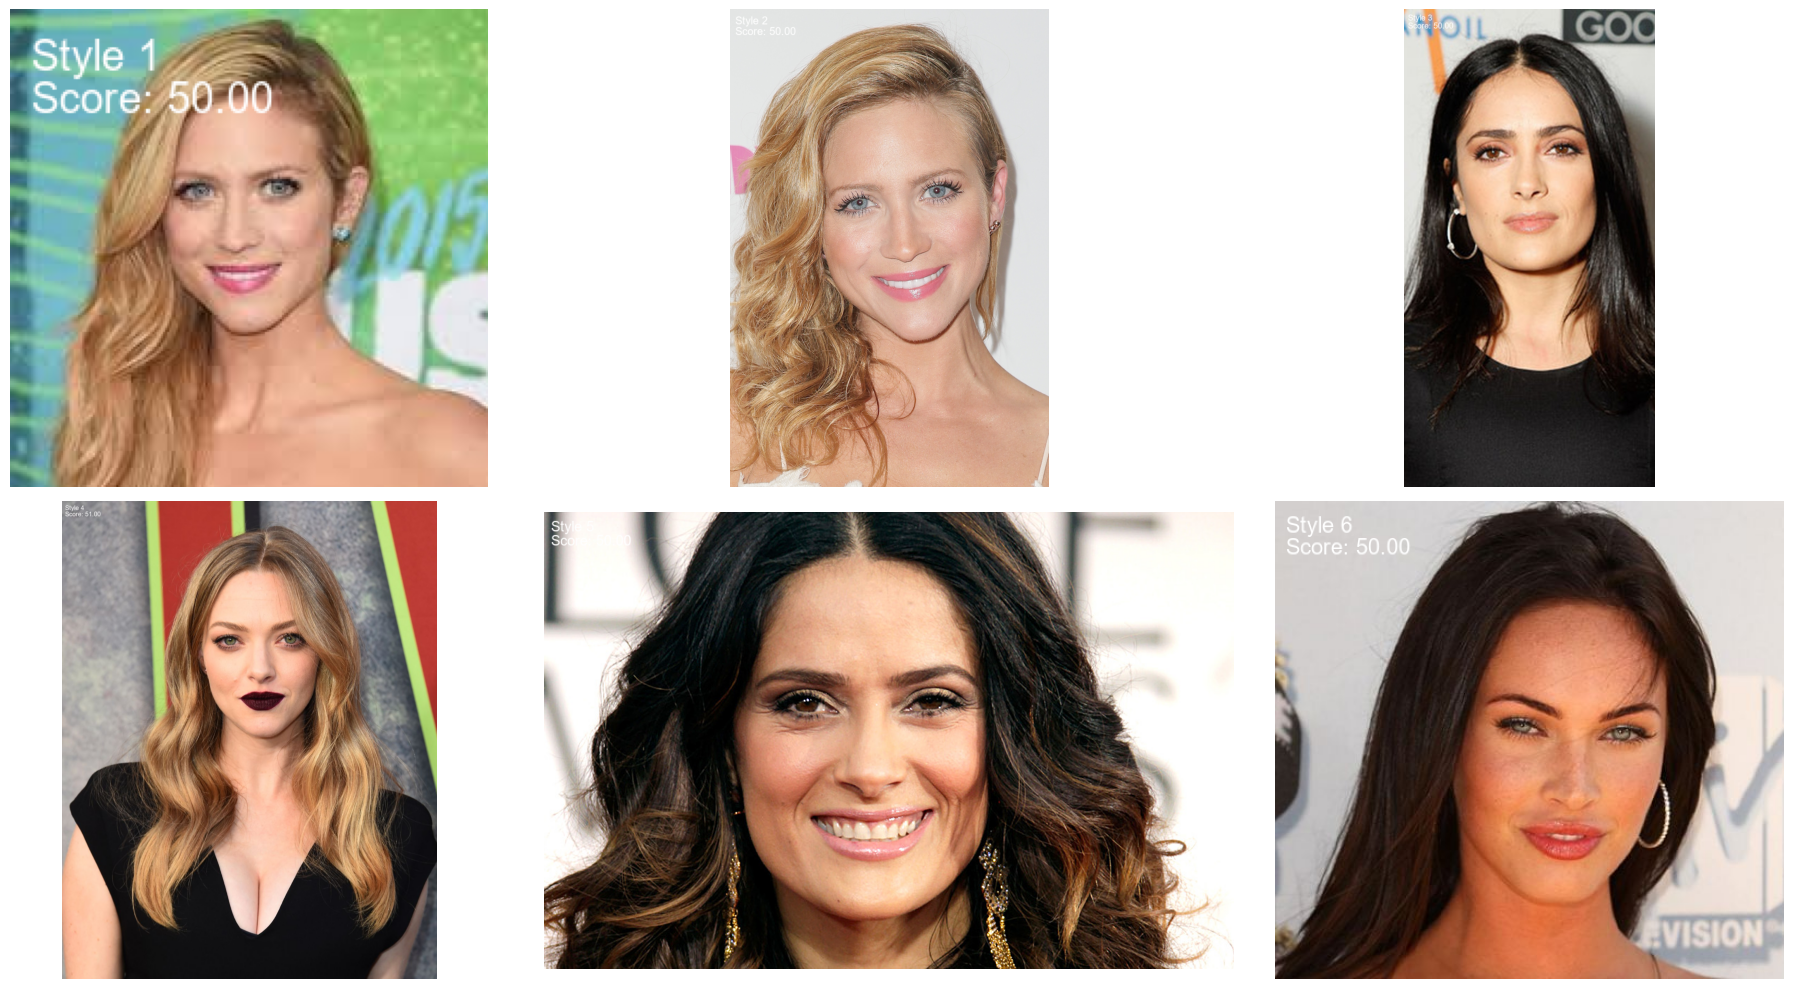

In [ ]:
# Run the recommender
if __name__ == "__main__":
    run_recommender()